# Image channels processing and alignment

## Problem review

Sergey Prokudin-Gorsky was the first color photographer in Russia, who made the color portrait of Leo Tolstoy. Each of his photographs is three black-and-white photo plates, corresponding to red, green, and blue color channels. Currently, the collection of his pictures is situated in the U.S. Library of Congress, the altered versions have proliferated online. In this task, you should make a programme which will align the images from the Prokudin-Gorsky plates and learn the basic image processing methods.


In [3]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import cv2

Populating the interactive namespace from numpy and matplotlib


## Input image loading

The input image is the set of 3 plates, corresponding to B, G, and R channels (top-down). You should implement the function $\tt{load}$\_$\tt{data}$ that reads the data and returns the list of images of plates.
$\tt{dir}$\_$\tt{name}$ is the path to the directory with plate images. If this directory is located in the same directory as this notebook, then default arguments can be used.

In [5]:
def load_data(dir_name = 'plates'):
    images = []
    for image in os.listdir(dir_name):
        img=plt.imread(dir_name+'/'+image)
        images.append(img[:,:,0])
    return np.array(images)

plates = load_data()

The dataset is a list of 2-dimensional arrays.

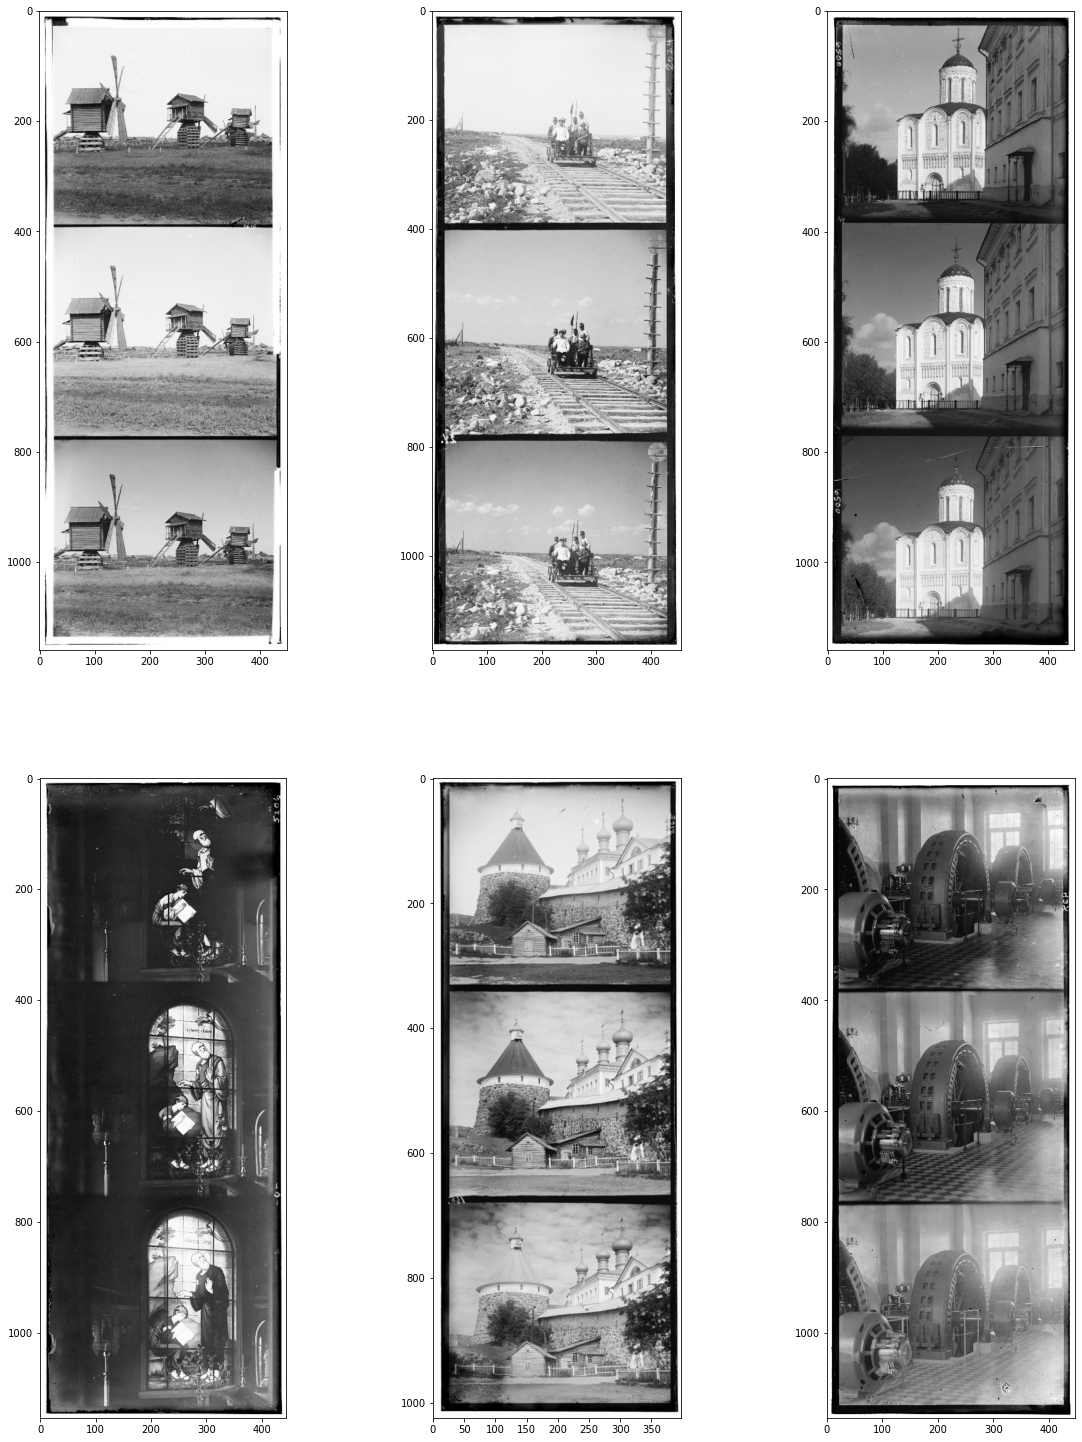

In [6]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(plates, 'gray')

#### The borders removal 
It is worth noting that there is a framing from all sides in most of the images. This framing can appreciably worsen the quality of channels alignment. Here, we suggest that you find the borders on the plates using Canny edge detector, and crop the images according to these edges.

The borders can be removed in the following way:
* Apply Canny edge detector to the image.
* Find the rows and columns of the frame pixels. 

For example, in case of upper bound we will search for the row in the neighborhood of the upper edge of the image (e.g. 5% of its height). For each row let us count the number of edge pixels (obtained using Canny detector) it contains. Having these number let us find two maximums among them. Two rows corresponding to these maximums are edge rows. As there are two color changes in the frame (firstly, from light scanner background to the dark tape and then from the tape to the image), we need the second maximum that is further from the image border. The row corresponding to this maximum is the crop border. In order not to find two neighboring peaks, non-maximum suppression should be implemented: the rows next to the first maximum are set to zero, and after that, the second maximum is searched for.

#### Canny detector implementation 
You can write your own implementation of Canny edge detector to get extra points. <br>

Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively: 
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, you can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

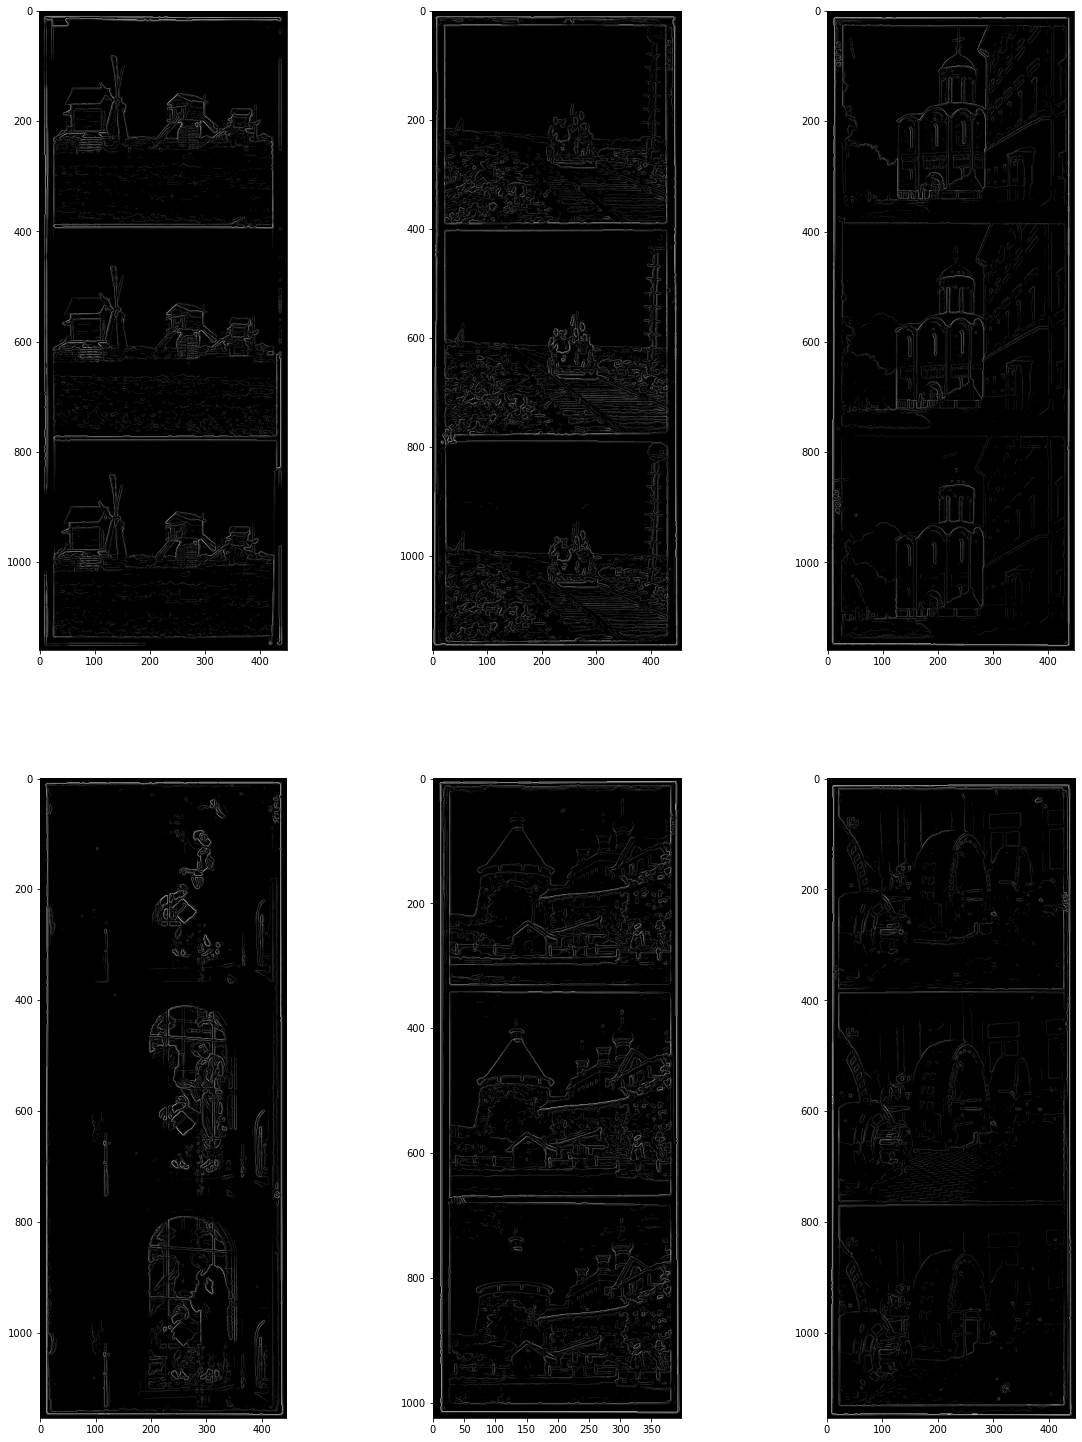

In [9]:
#defining teh custom canny detector
def Canny_detector(img,weak_th=None,strong_th=None):     
    #Noise reduction step
    img=cv2.GaussianBlur(img,(5,5),1.4)
    #Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0,3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1,3)

    mag, ang = cv2.cartToPolar(gx, gy,angleInDegrees=True)
    
    #setting the minimum and maximum thresholds for double thresholding
    mag_max=np.max(mag)
    if not weak_th:weak_th=mag_max*0.1
    if not strong_th:strong_th=mag_max*0.5   
    height,width=img.shape
    
    for i_x in range(width):
        for i_y in range(height):
            
            grad_ang=ang[i_y,i_x]
            grad_ang=abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
            
            #selecting the neigbours of the target pixel according to the gradient direction
            if grad_ang<=22.5:
                neighb_1_x,neighb_1_y=i_x-1,i_y
                neighb_2_x,neighb_2_y=i_x+1,i_y
            elif grad_ang>22.5 and grad_ang<=(22.5+45):
                neighb_1_x,neighb_1_y=i_x-1,i_y-1
                neighb_2_x,neighb_2_y=i_x+1,i_y+1
            elif grad_ang>(22.5+45) and grad_ang<=(22.5+90):
                neighb_1_x,neighb_1_y=i_x,i_y-1
                neighb_2_x,neighb_2_y=i_x,i_y+1
            elif grad_ang>(22.5+90) and grad_ang<=(22.5+135):
                neighb_1_x,neighb_1_y=i_x-1,i_y+1
                neighb_2_x,neighb_2_y=i_x+1,i_y-1
            elif grad_ang>(22.5+135) and grad_ang<=(22.5+180):
                neighb_1_x,neighb_1_y=i_x-1,i_y
                neighb_2_x,neighb_2_y=i_x+1,i_y
            
            #Non-maximum supression step
            if width>neighb_1_x>=0 and height>neighb_1_y>=0:
                if mag[i_y,i_x]<mag[neighb_1_y,neighb_1_x]:
                    mag[i_y,i_x]=0
                    continue

            if width>neighb_2_x>=0 and height>neighb_2_y>=0:
                if mag[i_y,i_x]<mag[neighb_2_y,neighb_2_x]:
                    mag[i_y,i_x]=0

    weak_ids=zeros_like(img)
    strong_ids=zeros_like(img)              
    ids=zeros_like(img)
    
    #double thresholding step
    for i_x in range(width):
        for i_y in range(height):
            grad_mag=mag[i_y,i_x]
            if grad_mag<weak_th:
                mag[i_y,i_x]=0
            elif strong_th>grad_mag>=weak_th:
                ids[i_y,i_x]=1
            else:
                ids[i_y,i_x]=2
    
    
    
    return mag


canny_imgs = []
for img in plates:
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
visualize(canny_imgs, 'gray')

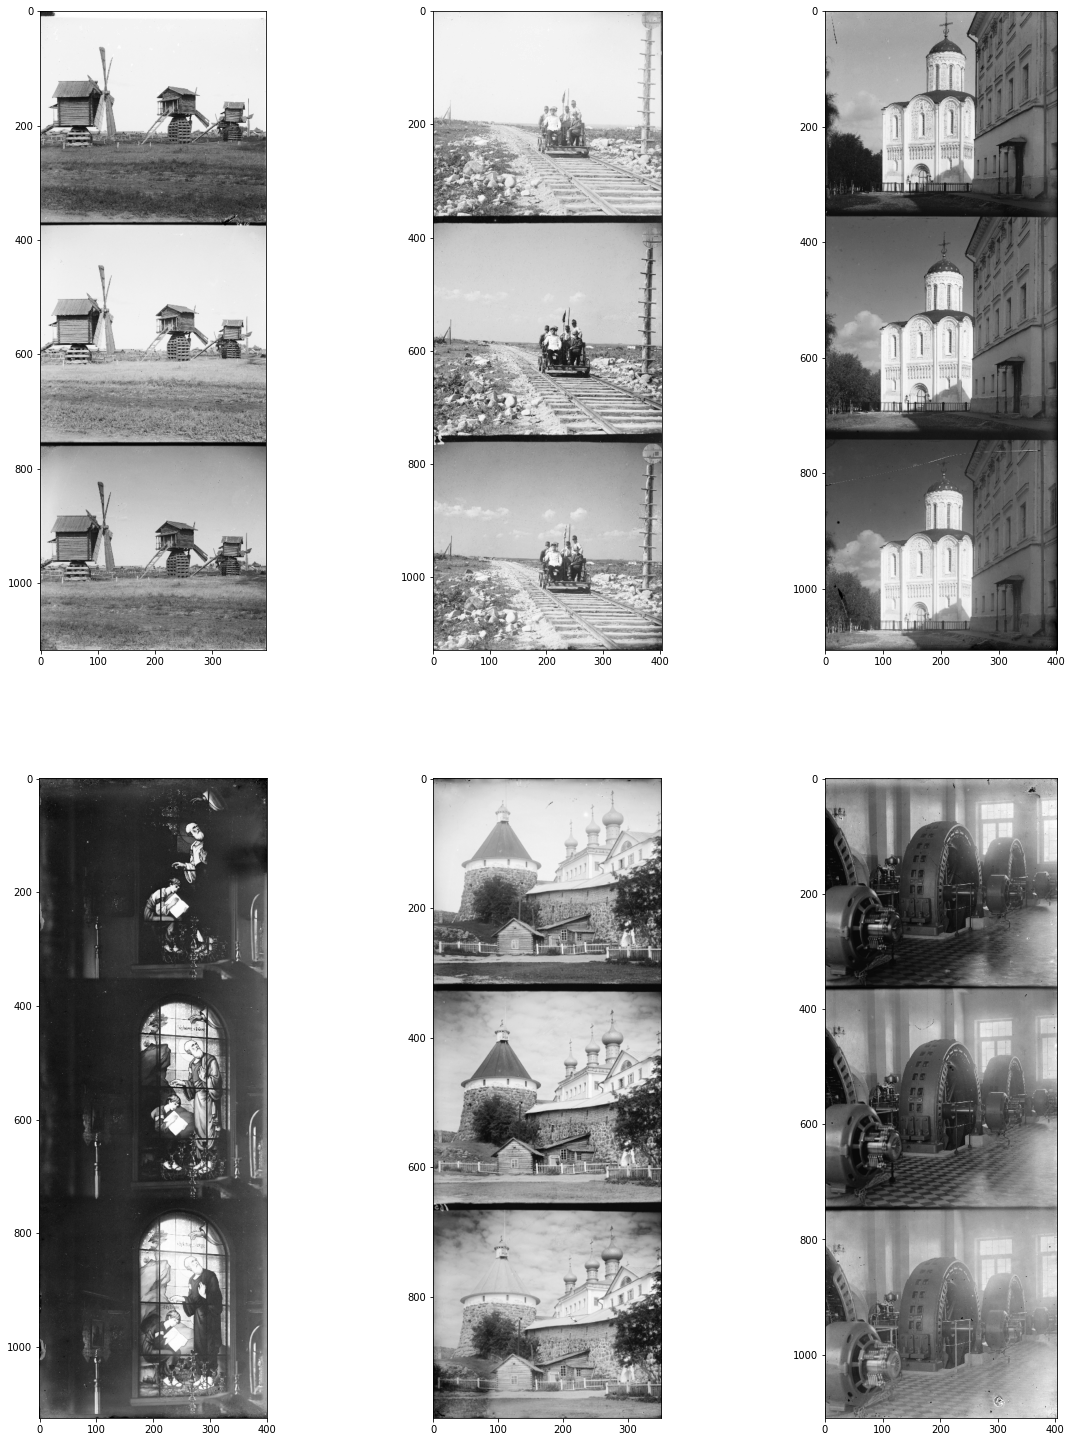

In [10]:
#Function for getting the maximum row sum out of input array 
def two_max(arr,index='higher'):
    "returns index of max from front or the 2nd max element from the end"
    max1=max(arr)
    max1_index=np.where(arr==max1)[0][0]
    arr[max1_index-5:max1_index+5]=-999
    max2=max(arr)
    max2_index=np.where(arr==max2)[0][0]
    if index=='higher':
        return max(max2_index,max1_index)
    else:
        return min(max2_index,max1_index)-len(arr)
    
    
def remove_borders(img, canny_img):
    """ Your implementation instead of the following one"""
    
    height,width=canny_img.shape
    
    #top and bottom borders
    row_sums=np.sum(canny_img,axis=1)
    bottom_sums=row_sums[-int(np.ceil(height*0.03)):]  #scan smaller fraction for height since height~3*width
    bottom_border_index=two_max(bottom_sums,index='lower')   #and borders are roughly the same size
    
    top_sums=row_sums[0:int(np.ceil(height*0.03))]
    top_border_index=two_max(top_sums)
    
    #left and right borders
    col_sums=np.sum(canny_img,axis=0)
    right_sums=col_sums[-int(np.ceil(width*0.075)):]
    right_border_index=two_max(right_sums,index='lower')
    left_sums=col_sums[0:int(np.ceil(width*0.075))]
    left_border_index=two_max(left_sums)
    
    return img[top_border_index+1 : bottom_border_index,left_border_index+1 : right_border_index]


cropped_imgs = []
#crop borders
for i, img in enumerate(plates):
    cropped_imgs.append(remove_borders(img, canny_imgs[i]))

visualize(cropped_imgs, 'gray')

#### Channels separation  (0.5 points)

The next step is to separate the image into three channels (B, G, R) and make one colored picture. To get channels, you can divide each plate into three equal parts.

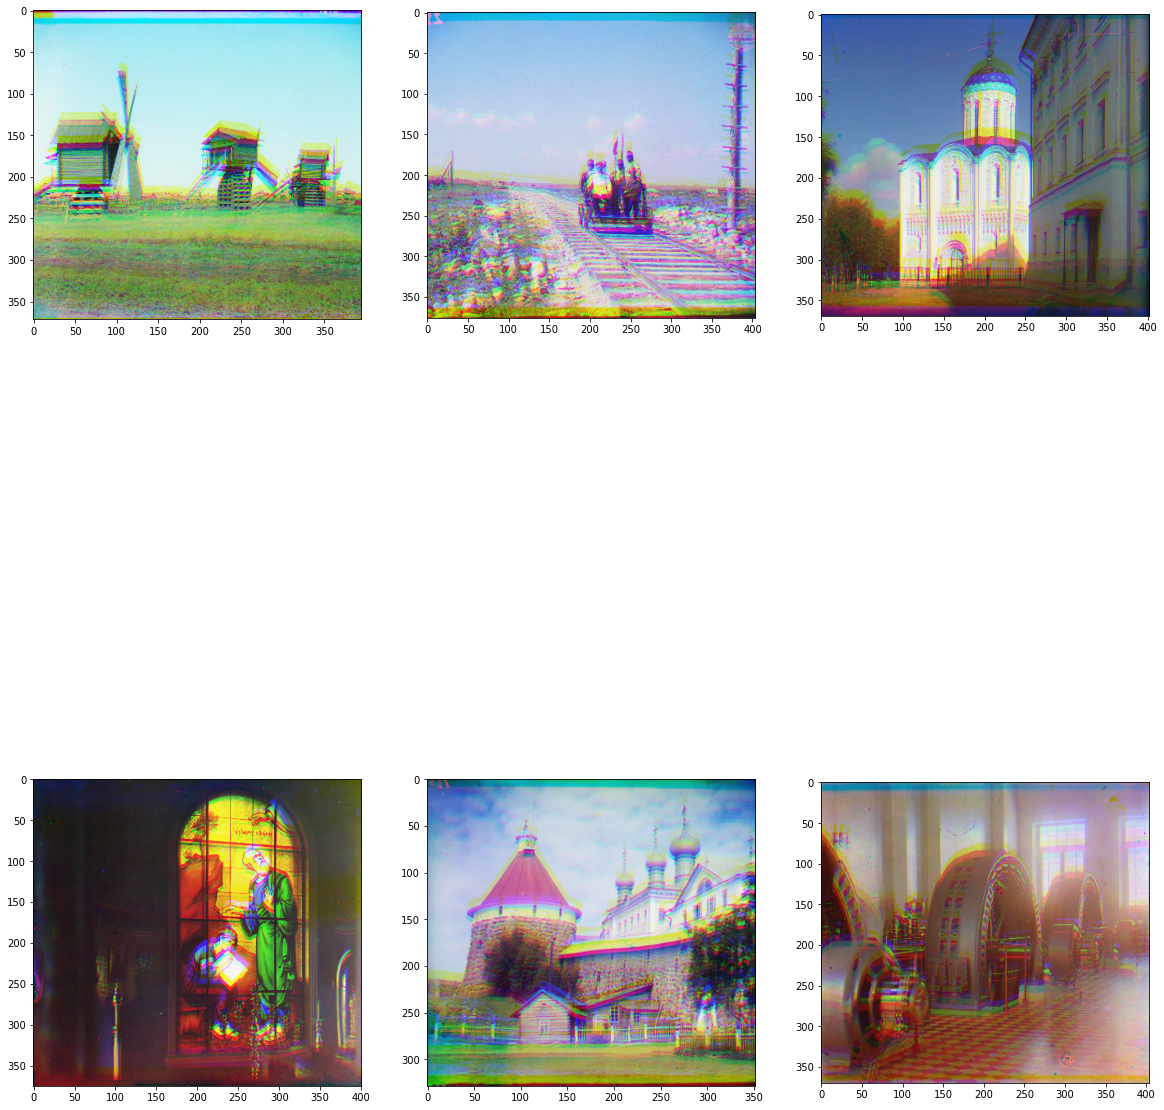

In [11]:
#Finally imposing the required components
def impose_components(img):
    """ Your implementation """
    height=img.shape[0]//3
    B_filter=img[:height]
    G_filter=img[height:2*height]
    R_filter=img[2*height:3*height]
    return np.stack([R_filter,G_filter,B_filter],axis=0)


rgb_imgs = []
for cropped_img in cropped_imgs:
    rgb_img = impose_components(cropped_img)
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

#### Search for the best shift for channel alignment

In order to align two images, we will shift one image relative to another within some limits (e.g. from $-15$ to $15$ pixels). For each shift, we can calculate some metrics in the overlap of the images. Depending on the metrics, the best shift is the one the metrics achieves the greatest or the smallest value for. We suggest that you implement two metrics and choose the one that allows to obtain the better alignment quality:

* *Mean squared error (MSE):*<br><br>
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$<br> where *w, h* are width and height of the images, respectively. To find the optimal shift you should find the minimum MSE over all the shift values.
    <br><br>
* *Normalized cross-correlation (CC):*<br><br>
    $$
    I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}.
    $$<br>
    To find the optimal shift you should find the maximum CC over all the shift values.

In [12]:
#Defining the metrics for the cost computation
def mse(X, Y):
    """ Your implementation """
    return np.mean(np.square(X-Y))

def cor(X, Y):
    """ Your implementation """
    return (np.sum(X*Y)/(np.sum(X)*np.sum(Y)))

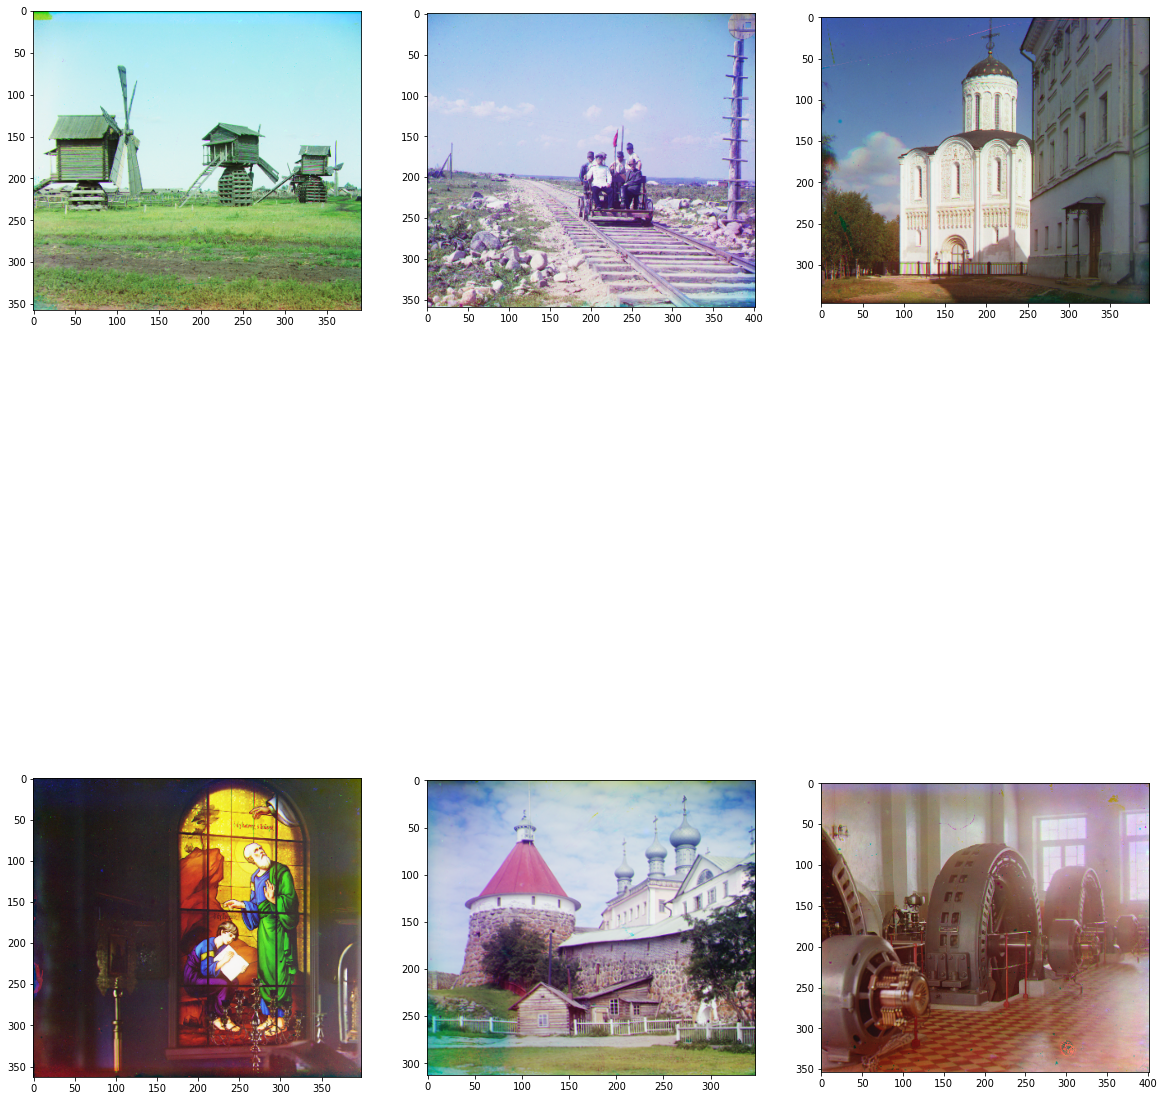

In [13]:
#Implementing the algorithm for finding the best arrangement of plates

def get_best_shift(channel1, channel2,metric='mse',shift_range=15):
    """ Your implementation """
    
    best_cor=cor(channel1,channel2)
    best_mse=mse(channel1,channel2)
    best_shift_w,best_shift_h=0,0

    for shift_h in range(-shift_range,shift_range+1):
        for shift_w in range(-shift_range,shift_range+1):
            
            if shift_w==0 and shift_h==0:continue
            chan1_w_start=max(0,shift_w)
            chan1_w_end=shift_w if shift_w<0 else None
            chan2_w_start=max(shift_w*-1,0)
            chan2_w_end=None if shift_w<=0 else shift_w*-1
            
            chan1_h_start=max(0,shift_h)
            chan1_h_end=shift_h if shift_h<0  else None
            chan2_h_start=max(shift_h*-1,0)
            chan2_h_end=None if shift_h<=0 else shift_h*-1
            
            chan_1_overlap=channel1[chan1_h_start:chan1_h_end,chan1_w_start:chan1_w_end]
            chan_2_overlap=channel2[chan2_h_start:chan2_h_end,chan2_w_start:chan2_w_end]
        
            if metric=='mse':
                temp_mse=mse(chan_1_overlap,chan_2_overlap)
                if temp_mse<best_mse:
                    best_mse=temp_mse
                    best_shift_w=shift_w
                    best_shift_h=shift_h
            else:
                temp_cor=cor(chan_1_overlap,chan_2_overlap)
                if temp_cor>best_cor:
                    best_cor=temp_cor
                    best_shift_w=shift_w
                    best_shift_h=shift_h  
    return best_shift_h,best_shift_w



def _best_image(channel1,channel2,channel3,metric='mse',shift_range=15):
    """ Your implementation """
    
    shift_h,shift_w=get_best_shift(channel1,channel2,metric,shift_range)
    chan1_w_start=max(0,shift_w)
    chan1_w_end=shift_w if shift_w<0 else None
    chan2_w_start=max(shift_w*-1,0)
    chan2_w_end=None if shift_w<=0 else shift_w*-1
            
    chan1_h_start=max(0,shift_h)
    chan1_h_end=shift_h if shift_h<0  else None
    chan2_h_start=max(shift_h*-1,0)
    chan2_h_end=None if shift_h<=0 else shift_h*-1
    
    chan_1_overlap=channel1[chan1_h_start:chan1_h_end,chan1_w_start:chan1_w_end]
    chan_2_overlap=channel2[chan2_h_start:chan2_h_end,chan2_w_start:chan2_w_end]
    chan_3_overlap=channel3[chan2_h_start:chan2_h_end,chan2_w_start:chan2_w_end]
 
    chan_ave=(chan_1_overlap+chan_2_overlap)/2
    shift_h,shift_w=get_best_shift(chan_3_overlap,chan_ave,metric,shift_range)
    chan3_w_start=max(0,shift_w)
    chan3_w_end=shift_w if shift_w<0 else None
    chan2_w_start=max(shift_w*-1,0)
    chan2_w_end=None if shift_w<=0 else shift_w*-1
            
    chan3_h_start=max(0,shift_h)
    chan3_h_end=shift_h if shift_h<0  else None
    chan2_h_start=max(shift_h*-1,0)
    chan2_h_end=None if shift_h<=0 else shift_h*-1
    
    chan_3_overlap=chan_3_overlap[chan3_h_start:chan3_h_end,chan3_w_start:chan3_w_end]
    chan_2_overlap=chan_2_overlap[chan2_h_start:chan2_h_end,chan2_w_start:chan2_w_end]
    chan_1_overlap=chan_1_overlap[chan2_h_start:chan2_h_end,chan2_w_start:chan2_w_end]
 
    return chan_1_overlap,chan_2_overlap,chan_3_overlap


def get_best_image(rgb_img,metric='mse'):
    """ Your implementation """
    channel1,channel2,channel3=rgb_img
    
    chan1_aligned,chan2_aligned,chan3_aligned=_best_image(channel1,channel2,channel3,metric,15)
    
    chan2_aligned,chan3_aligned,chan1_aligned=_best_image(chan2_aligned,chan3_aligned,chan1_aligned,metric,10)
    
    chan3_aligned,chan1_aligned,chan2_aligned=_best_image(chan3_aligned,chan1_aligned,chan2_aligned,metric,5)

    return np.stack([chan1_aligned,chan2_aligned,chan3_aligned],axis=0)
final_imgs = []
for img in rgb_imgs:
    final_img =get_best_image(img,metric='mse')
    #final_img =get_best_image(final_img,metric='corr')#mse produces much better results
    final_imgs.append(final_img)

visualize(final_imgs)